<a href="https://colab.research.google.com/github/carolchucrekappel/MVP1/blob/main/MVP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP 1 - Privacidade e segurança: Classificação de transações

# 1. Definição do Problema
O Brasil é um dos países mais visados por crimes cibernéticos,  especialmente fraudes bancárias (Bhardwaj et al. 2021). O objetivo deste projeto é desenvolver um Mínimo Produto Viável (MVP) de um modelo de machine learning para prever se uma transação é fraudulenta ou não. Para tanto, utilizaremos um modelo de classificação que toma como base características como valor da transação, saldo inicial e posterior. Com esse produto buscamos propor uma ferramenta que pode auxiliar no combate a fraudes financeiras.

Para isso, utilizaremos o dataset "Financial Fraud Detection Dataset" do repositório Kaggle. O problema será modelado como uma classificação binária, onde o objetivo é distinguir transações fraudulentas de transações lícitas.

## Hipótese
As características de uma transação financeira (como tipo de transação, tempo, valor, etc.) contêm informações suficientes para prever se ela é lícita ou não.

## Dataset

*   Fonte: Kaggle
*   Link: [Financial Fraud Detection Dataset](https://www.kaggle.com/datasets/sriharshaeedala/financial-fraud-detection-dataset/data)
* Atributos: O dataset possui 3 atributos categóricos, 7 atributos numéricos (features) - sendo 5 contínuos e 2 discretos -, e 1 variável alvo ("is fraud").

## Configuração do Ambiente

In [1]:
# API do kaggle
import kagglehub

# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt

# Pré-processamento de dados
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from collections import Counter

# Modelos de aprendizado de máquina
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Métricas de avaliação
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Configurações de visualização para os gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Ambiente configurado e bibliotecas importadas com sucesso!")

Ambiente configurado e bibliotecas importadas com sucesso!


# 2. Preparação dos Dados
Nesta etapa, realizamos as operações de carga, limpeza e transformação dos dados para prepará-los para a modelagem.

## Operações Realizadas


1.   **Carga dos Dados**: O dataset é carregado diretamente de uma URL pública, garantindo a reprodutibilidade do notebook.
2.   **Engenharia de Features**: As variáveis categóricas são transformadas (como a variável 'type') ou descartadas (como as variáveis origem e destino). Além disso, também são descartadas variáveis com muitos valores únicos e que não contribuem para o modelo. Dessa forma, o modelo é treinado apenas com base em dados realmente relevantes.
3. **Separação em Treino e Teste**: O dataset é dividido em 80% para treino e 20% para teste. Utilizamos a amostragem estratificada para garantir que a proporção de fraudes e transações lícitas seja a mesma em ambos os conjuntos, o que é crucial para datasets com classes desbalanceadas, como é o caso de datasets de transações fraudulentas.
4. **Padronização (Scaling)**: Criamos uma versão padronizada dos dados (média 0, desvio padrão 1). Embora modelos baseados em árvores (como o Random Forest) não necessitem desta etapa, ela é fundamental para modelos sensíveis à escala, como a Regressão Logística, que usaremos como baseline.

## Implementação

### 2.1. Carga dos dados

In [2]:
# Download da última versão do dataset
path = kagglehub.dataset_download("sriharshaeedala/financial-fraud-detection-dataset")

# Carregar os dados em formato pandas
# O dataset é um arquivo CSV no diretório downloaded
import os
csv_file_path = os.path.join(path, 'Synthetic_Financial_datasets_log.csv')
data = pd.read_csv(csv_file_path)

print("--- Amostra do Dataset Original ---")
display(data.head())

Using Colab cache for faster access to the 'financial-fraud-detection-dataset' dataset.
--- Amostra do Dataset Original ---


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### 2.2. Engenharia de Features e definição de variável alvo



In [3]:
# Exibir informações gerais do dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


In [4]:
# A variável 'type' é transformada em numérica pelo One-Hot Encoding
if 'type' in data.columns:
    data = pd.get_dummies(data, columns=['type'], drop_first=True)

# Remover colunas com muitos valores únicos que não são úteis para o modelo
columns_to_drop = [col for col in ['nameOrig', 'nameDest', 'step', 'isFlaggedFraud'] if col in data.columns]
data = data.drop(columns=columns_to_drop, errors='ignore')

display(data.head())

print(data.info())

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.0,160296.36,0.0,0.0,0,False,False,True,False
1,1864.28,21249.0,19384.72,0.0,0.0,0,False,False,True,False
2,181.00,181.0,0.00,0.0,0.0,1,False,False,False,True
3,181.00,181.0,0.00,21182.0,0.0,1,True,False,False,False
4,11668.14,41554.0,29885.86,0.0,0.0,0,False,False,True,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   amount          float64
 1   oldbalanceOrg   float64
 2   newbalanceOrig  float64
 3   oldbalanceDest  float64
 4   newbalanceDest  float64
 5   isFraud         int64  
 6   type_CASH_OUT   bool   
 7   type_DEBIT      bool   
 8   type_PAYMENT    bool   
 9   type_TRANSFER   bool   
dtypes: bool(4), float64(5), int64(1)
memory usage: 315.5 MB
None



--- Distribuição das Classes (0 = Não fraude, 1 = Fraude) ---
isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


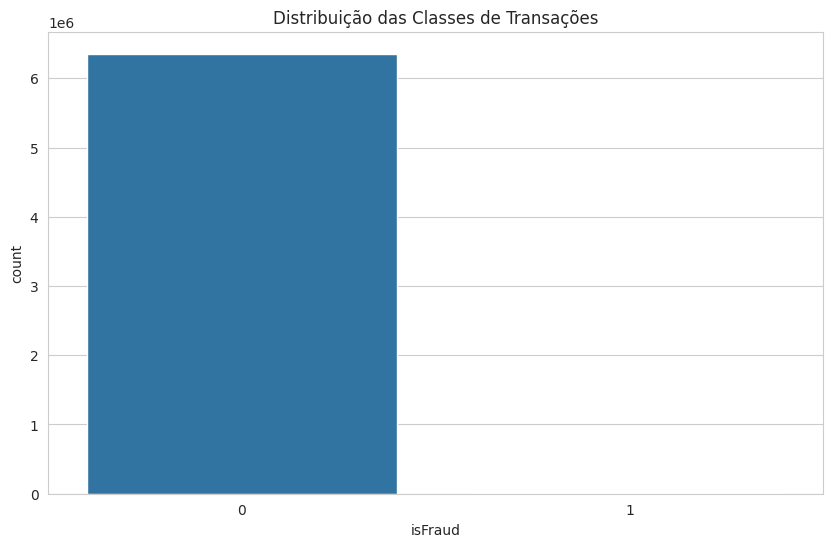

In [5]:
# Separando as features (X) e o alvo (y)
X = data.drop(['isFraud'], axis=1)
y = data['isFraud']

print("\n--- Distribuição das Classes (0 = Não fraude, 1 = Fraude) ---")
print(y.value_counts(normalize=True))
sns.countplot(x=y)
plt.title('Distribuição das Classes de Transações')
plt.show()

2.3. Separação em Treino e Teste (Estratificada)

In [6]:
# Vamos usar 80% para treinar e 20% para testar
# Utilizamos stratify=y para garantir que a proporção das classes seja mantida nos conjuntos de treino e teste
# O random state permite a reprodutibilidade do modelo
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nFormato dos dados de treino: {X_train.shape}")
print(f"Formato dos dados de teste: {X_test.shape}")


Formato dos dados de treino: (5090096, 9)
Formato dos dados de teste: (1272524, 9)


2.4. Padronização dos Dados

In [7]:
# Embora a normalização não afete modelos de Random Forest (a divisão independe da magnitude dos valores)
# Isso é relevante para modelos sensíveis à escala, como a regressão logística, que é a baseline do projeto
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("\nDados padronizados com sucesso para uso em modelos sensíveis à escala.")


Dados padronizados com sucesso para uso em modelos sensíveis à escala.


# 3. Modelagem e Treinamento
Nesta seção, construímos e treinamos os modelos de machine learning. A abordagem escolhida foi:

* Modelo Baseline (Regressão Logística): Um modelo simples e rápido que serve como um ponto de referência. Se um modelo mais complexo não superar significativamente este baseline, sua complexidade pode não ser justificada. Em casos de classificação de fraudes, ele pode não ser ideal por não ser capaz de capturar relações complexas nos dados de fraude.

* Modelo Principal (Random Forest): É uma técnica simples, precisa e flexível, que consegue lidar com um grande número de características (variáveis). Possui utilização na detecção de anomalias e pode ser usado para a classificação das transações em fraudulentas ou não. Além disso, consegue lidar com dados desequilibrados, como é o caso.

* Análise de Feature Importance: Após treinar o Random Forest inicial, analisamos quais atributos mais influenciaram suas decisões. Isso nos ajuda a entender o "raciocínio" do modelo e a validar se ele está focando em características relevantes.

##Implementação

3.1. Modelo Baseline: Regressão Logística

In [8]:
# Usamos 'class_weight' para lidar com o desbalanceamento
# O balanceamento de classes lida com o desbalanceamento dando maior peso à classe minoritária, assim o modelo
# valoriza a classe de fraude


log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train) # Treinamento com os dados balanceados
print("Modelo de Regressão Logística treinado.")

Modelo de Regressão Logística treinado.


3.2. Modelo Principal: Random Forest Classifier

In [9]:
# Criar uma instância do modelo Random Forest
# Utilizamos 100 para a quantidade de árvores a serem criadas (n_estimators)
# n_jobs=-1 usa todos os núcleos disponíveis na máquina
# Não precisa de dados escalados
print("\n--- Treinando Modelo Principal: Random Forest ---")
rf_initial = RandomForestClassifier(
    random_state=42, class_weight='balanced', n_estimators=100, n_jobs=-1
)
rf_initial.fit(X_train, y_train)
print("Modelo Random Forest Inicial treinado.")


--- Treinando Modelo Principal: Random Forest ---
Modelo Random Forest Inicial treinado.


3.3. Análise de Feature Importance


--- Análise de Importância das Features (Random Forest) ---


/tmp/ipython-input-2422447289.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


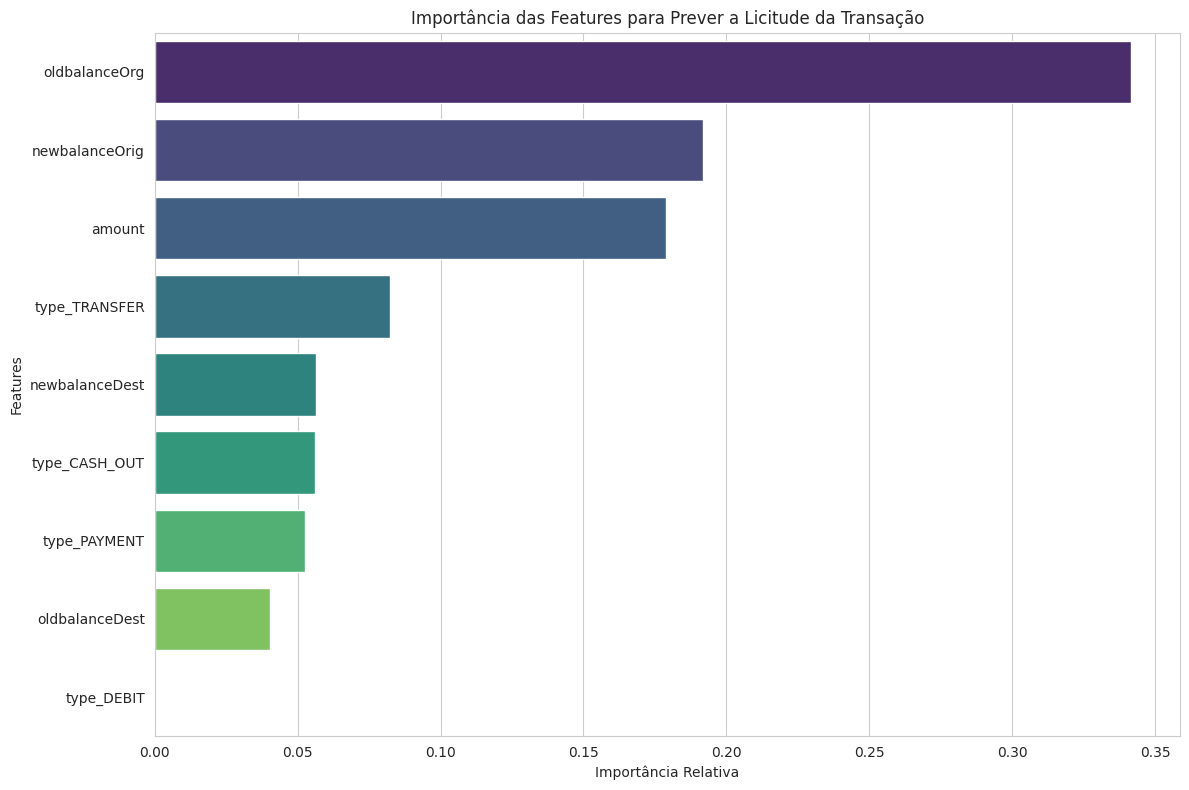

,feature,importance
1,oldbalanceOrg,0.341607
2,newbalanceOrig,0.191678
0,amount,0.178756
8,type_TRANSFER,0.082161
4,newbalanceDest,0.056546
5,type_CASH_OUT,0.056196
7,type_PAYMENT,0.052458
3,oldbalanceDest,0.040351
6,type_DEBIT,0.000247


In [10]:
print("\n--- Análise de Importância das Features (Random Forest) ---")
importances = rf_initial.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Importância das Features para Prever a Licitude da Transação')
plt.xlabel('Importância Relativa')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

display(feature_importance_df)

# 4. Otimização de Hiperparâmetros
Um modelo de machine learning possui "botões" (hiperparâmetros) que controlam seu comportamento. Para extrair a máxima performance do Random Forest, utilizamos a técnica GridSearchCV, que realiza uma busca exaustiva pela melhor combinação desses hiperparâmetros.

## Justificativa

* **Validação Cruzada** (cv=3): O GridSearchCV utiliza validação cruzada para avaliar cada combinação de parâmetros. Isso fornece uma estimativa muito mais robusta da performance do modelo em dados não vistos, prevenindo a escolha de parâmetros que funcionam bem por mero acaso em uma única divisão de dados.

* **Métrica de Otimização** (F1-Score): Como o dataset é altamente desbalanceado, otimizar apenas pela acurácia seria um erro, pois, como a classe minoritária (fraude) é mínima, se o modelo previsse tudo como não fraude, ele teria uma elevada acurácia, no entanto, o recall da classe minoritária seria ruim. Escolhemos o f1_score, que representa uma média harmônica entre precisão e recall, fornecendo uma medida de performance muito mais equilibrada e confiável para este tipo de problema.

## Implementação

In [12]:
print("--- Otimizando o Random Forest com GridSearchCV ---")

# Definindo a grade de parâmetros para testar
param_grid = {
    'n_estimators': [150, 200], # número de árvores
    'max_features': ['sqrt', 'log2'], # quantidade de features consideradas na divisão dos nós. 'auto' foi renomeado para 'sqrt'
    'max_depth': [20, None], # limite para a profundidade da árvore
    'min_samples_leaf': [1, 2] # quantidade mínima de amostras necessárias que deve resultar da divisão dos nós
}

# Criar o objeto GridSearchCV
# Otimizar pelo F1-score, que é bom para dados desequilibrados
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3, # Número de folds para validação cruzada (3 ou 5 são comuns)
                           scoring='f1', # Métrica a ser otimizada
                           n_jobs=-1, # Usa todos os núcleos disponíveis
                           verbose=2) # Para ver o progresso

# Executar a busca nos dados de treino
grid_search.fit(X_train, y_train)

# Obter o melhor modelo e os melhores parâmetros
print(f"\nMelhores hiperparâmetros encontrados: {grid_search.best_params_}")

# O melhor modelo já treinado com os melhores parâmetros
rf_optimized = grid_search.best_estimator_
print(f"Melhor F1-score na validação cruzada: {grid_search.best_score_:.4f}")

--- Otimizando o Random Forest com GridSearchCV ---
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Melhores hiperparâmetros encontrados: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200}
Melhor F1-score na validação cruzada: 0.8599


# 5. Avaliação Final e Conclusão
Esta é a etapa final, onde avaliamos a performance dos nossos modelos no conjunto de teste — dados que eles nunca viram antes. Isso nos dá a melhor estimativa de como os modelos se comportariam em um cenário real.

## Análise dos Resultados
* **Comparação de Modelos**: Comparamos a performance (Acurácia e F1-Score) dos três modelos: o baseline, o Random Forest inicial e o Random Forest otimizado.

* **Análise de Overfitting**: Verificamos se o modelo final está "decorando" os dados de treino (overfitting) ou se ele generaliza bem para novos dados. Fazemos isso comparando sua pontuação no conjunto de treino com a do conjunto de teste.

* **Matriz de Confusão**: Visualizamos os erros e acertos do melhor modelo para entender que tipo de erros ele mais comete (ex: classificar uma transação fraudulenta como lícita, ou vice-versa).

* **Conclusão**: A melhor solução encontrada será o modelo com a maior performance no conjunto de teste, demonstrando que a abordagem de modelagem e otimização foi bem-sucedida.

## Implementação

In [13]:
print("--- Avaliação Final dos Modelos no Conjunto de Teste ---")

# Fazendo previsões com todos os modelos
y_pred_log_reg = log_reg.predict(X_test_scaled)
y_pred_rf_initial = rf_initial.predict(X_test)
y_pred_rf_optimized = rf_optimized.predict(X_test)

--- Avaliação Final dos Modelos no Conjunto de Teste ---


5.1. Tabela Comparativa de Resultados

In [16]:
results = {
    "Modelo": [
        "Regressão Logística (Baseline)",
        "Random Forest Inicial",
        "Random Forest Otimizado"
    ],
    "Acurácia": [
        accuracy_score(y_test, y_pred_log_reg),
        accuracy_score(y_test, y_pred_rf_initial),
        accuracy_score(y_test, y_pred_rf_optimized)
    ],
    "F1-Score ponderado": [
        float(classification_report(y_test, y_pred_log_reg, output_dict=True)['weighted avg']['f1-score']),
        float(classification_report(y_test, y_pred_rf_initial, output_dict=True)['weighted avg']['f1-score']),
        float(classification_report(y_test, y_pred_rf_optimized, output_dict=True)['weighted avg']['f1-score'])
    ]
}

results_df = pd.DataFrame(results).set_index("Modelo")
print("\n--- Tabela Comparativa de Performance ---\n")
display(results_df.round(4))


--- Tabela Comparativa de Performance ---



,Acurácia,F1-Score ponderado
Modelo,,
Regressão Logística (Baseline),0.9462,0.9711
Random Forest Inicial,0.9997,0.9997
Random Forest Otimizado,0.9997,0.9997


**Análise**: O quadro comparativo demonstra que o modelo baseline foi superado pelo random forest, o que justifica a adoção deste modelo, apesar de sua maior complexidade.
Quanto ao modelo inicial de random forest, a sua otimização pelo GridSearch não alterou seu desempenho. Nesse sentido, a opção pelo modelo inicial é justificada, considerando o alto custo computacional da otimização.

5.2. Relatório de Classificação Detalhado do Melhor Modelo

In [18]:
print("\n--- Relatório de Classificação - Random Forest Inicial ---")
print(classification_report(y_test, y_pred_rf_initial, target_names=['Não fraude (0)', 'Fraude (1)']))



--- Relatório de Classificação - Random Forest Inicial ---
                precision    recall  f1-score   support

Não fraude (0)       1.00      1.00      1.00   1270881
    Fraude (1)       0.97      0.79      0.87      1643

      accuracy                           1.00   1272524
     macro avg       0.98      0.90      0.93   1272524
  weighted avg       1.00      1.00      1.00   1272524



**Análise**: O quadro acima consolida os resultados das métricas de desempenho tanto para a Classe 0 (não fraude) quanto para a Classe 1 (fraude).
Precisão é a habilidade do modelo de não classificar como positiva uma amostra negativa (ou seja, não gerar falsos positivos); recall é a habilidade do classificador de identificar todas as amostras positivas; e f-1 score é a média harmônica entre esses dois valores, ambos igualmente importantes (Pedrodas et. al. 2025).
Para a Classe 0, precisão, recall e f-1 score atingiram valor máximo (1), ou seja, quando o modelo identificou uma transação não fraudulenta estava correto todas as vezes e ele foi capaz de identificar todas as transações desse tipo.
Para a Classe 1, a precisão foi de 0.97, ou seja, quando ele identificou uma transação como fraudulenta estava correto 97% das vezes. O recall foi de 0.79, ou seja, foi capaz de identificar 79% de todas as transações fraudulentas.

5.3. Análise de Overfitting do Melhor Modelo

In [19]:
train_score = rf_initial.score(X_train, y_train)
test_score = rf_initial.score(X_test, y_test)

print("\n--- Análise de Overfitting (Modelo Inicial) ---")
print(f"Pontuação (Acurácia) no conjunto de Treino: {train_score:.4f}")
print(f"Pontuação (Acurácia) no conjunto de Teste: {test_score:.4f}")

if train_score > test_score + 0.1:
    print("\nAlerta: Diferença significativa entre treino e teste. Pode haver overfitting.")
else:
    print("\nO modelo parece ter uma boa capacidade de generalização.")


--- Análise de Overfitting (Modelo Inicial) ---
Pontuação (Acurácia) no conjunto de Treino: 1.0000
Pontuação (Acurácia) no conjunto de Teste: 0.9997

O modelo parece ter uma boa capacidade de generalização.


**Análise**: Não houve diferença significativa entre o desempenho no conjunto de treino e no de teste, ou seja, o modelo não padece de overfiting.

5.4. Matriz de Confusão do Melhor Modelo


--- Matriz de Confusão (Modelo Inicial) ---


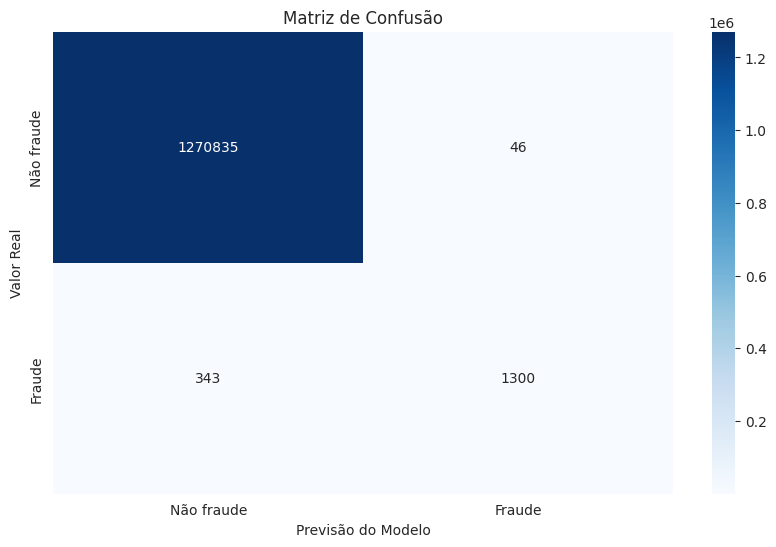

In [20]:
print("\n--- Matriz de Confusão (Modelo Inicial) ---")
cm = confusion_matrix(y_test, y_pred_rf_initial)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não fraude', 'Fraude'],
            yticklabels=['Não fraude', 'Fraude'])
plt.xlabel('Previsão do Modelo')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão')
plt.show()

**Análise**: A matriz de confusão confirma os resultados do relatório de classificação analisado acima. O modelo acertou a maioria das transações não fraudulentas e um número significativo das fraudulentas.
No entanto, a taxa de falsos negativos foi superior à de falsos positivos. Nesse sentido, a depender do enfoque que se pretenda dar ao modelo - reduzir falsos positivos ou detectar a maior parte das transações fraudulentas -, algumas medidas podem ser adotadas para aprimorá-lo, especialmente em relação às métricas da classe minoritária.

# Conclusões e Considerações Finais
Este MVP demonstrou a aplicação prática de técnicas de machine learning para resolver um problema real de classificação no setor financeiro. O projeto seguiu uma metodologia estruturada, desde a definição do problema até a avaliação final dos modelos.

## Principais Resultados
1. **Preparação de Dados Eficiente**: A preparação dos dados simplificou o problema ao focar apenas nas features realmente relevantes para o modelo.

2. **Comparação de Modelos**: A utilização de um modelo baseline (Regressão Logística) permitiu avaliar se a complexidade adicional do Random Forest era justificada.

3. **Otimização Sistemática**: O uso do GridSearchCV com validação cruzada garantiu uma seleção robusta de hiperparâmetros, confirmando a performance do modelo inicial.

4. **Avaliação Abrangente**: A análise incluiu múltiplas métricas (acurácia, F1-score), verificação de overfitting e visualização da matriz de confusão, proporcionando uma visão completa da performance do modelo. As métricas indicam que o modelo lida razoavelmente bem com o desequilíbrio da classe alvo e é capaz de identificar fraudes sem gerar um número excessivo de falsos positivos.

## Aplicações Práticas

O modelo desenvolvido pode ser aplicado em:

* Bloqueio automático de transações com alta suspeita de fraude para evitar a perda de ativos
* Sinalização de transações suspeitas para a revisão humana
* Redução de falsos positivos e melhora na relação com clientes bancários
* Aprimoramento das regras de segurança, a partir da identificação das características que mais influenciam na fraude

## Próximos Passos

Para trabalhos futuros, sugere-se:

* Exploração de outros algoritmos de machine learning, como SVM e gradient boosting
* Reamostragem com utilização de técnicas como SMOTE para lidar com o desequilíbrio de classes, com enfoque no aprendizado de padrões da classe minoritária
* Otimização dos parâmetros, p. ex., treinamento com quantidades diferentes de árvores
* Análise mais detalhada das features mais importantes
* Coleta de dados adicionais para melhorar a generalização
* Implementação de um sistema de monitoramento contínuo do modelo